Tegmark: How to make CMB maps? https://arxiv.org/pdf/astro-ph/9611130.pdf

The observed antenna temperature $T_A$ at a frequency $\nu$ is the convolution between the sky brightness temperature $T_b$ and the primary antenna beam $A_p$:

$$T_A(\nu) = \int \mathrm{d}\Omega A_p(\nu, \Omega) T_b(\nu, \Omega)$$

Our goal is to recover the sky brightness temperature as a function of position and frequency, i.e. making maps. 

We start by rewriting the convolution in terms of a dot product between spherical harmonics coefficients following e.g. [this derivation](https://github.com/christianhbye/croissant/blob/main/docs/math.md):

$$A_p(\Omega) = \sum_{\ell, m} a_\ell^m Y_{\ell}^m,\, T_b (\Omega) = \sum_{\ell, m} b_\ell^m Y_{\ell}^m \\
T_A = \sum_\ell a_l^0 b_l^0 + \sum_{\ell, m>0} \left(a_\ell^m \left(b_\ell^m\right)^* + \left(a_\ell^m\right)^* b_\ell^m\right) \\
T_A = \sum_\ell a_l^0 b_l^0 + 2 \sum_{\ell, m>0} \left(\Re{\left(a_\ell^m\right)} \Re{\left(b_\ell^m\right)} + \Im{\left(a_\ell^m\right)} \Im{\left(b_\ell^m\right)}\right) $$

This lets us rephrase the problem with linear algebra:

$$\mathbf{y} = \mathbf{A}\mathbf{x} + \mathbf{n},$$

where for any given frequency $\mathbf{y}$ is the observed data (the antenna temperature), $\mathbf{x}$ is a vector containing the coefficients of the sky spherical harmonics expansion, $\mathbf{n}$ is the noise, and $\mathbf{A}$ is a matrix of the spherical harmonics coefficients of the antenna beam..

Following Tegmark 1996, we use Wiener filtering (methods 4 and 5) to estimate $\mathbf{x}$ (which we denote by $\mathbf{\tilde{x}}$):

$$\mathbf{\tilde{x}} = \mathbf{W} \mathbf{y} \\
\mathbf{S} \equiv \langle \mathbf{x} \mathbf{x^t} \rangle,\,  \mathbf{N} \equiv \langle \mathbf{n} \mathbf{n^t} \rangle \\
\mathbf{W} = \mathbf{S}\mathbf{A^t} \left[\mathbf{A}\mathbf{S}\mathbf{A^t} + \mathbf{N}\right]^{−1}\; \textrm{(method 4)} \\
\mathbf{W} = \left[\mathbf{S}^{-1} + \mathbf{A^t} \mathbf{N}^{-1} \mathbf{A} \right]^{-1} \mathbf{A^t} \mathbf{N}^{−1}\; \textrm{(method 5)}$$

In [1]:
import croissant as cro
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

fatal: No names found, cannot describe anything.


In [4]:
theta = np.linspace(0, np.pi, num=181)
phi = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
phi.shape = (1, 1, -1)
freq = np.array([25])  # MHz
# dipole beam
power = freq[:, None]**2 * np.sin(theta[None, :])
power = np.repeat(power, phi.size, axis=-1)
beam = cro.beam.Beam.from_grid(power, theta=theta, phi=phi, frequencies=freq, lmax=5)

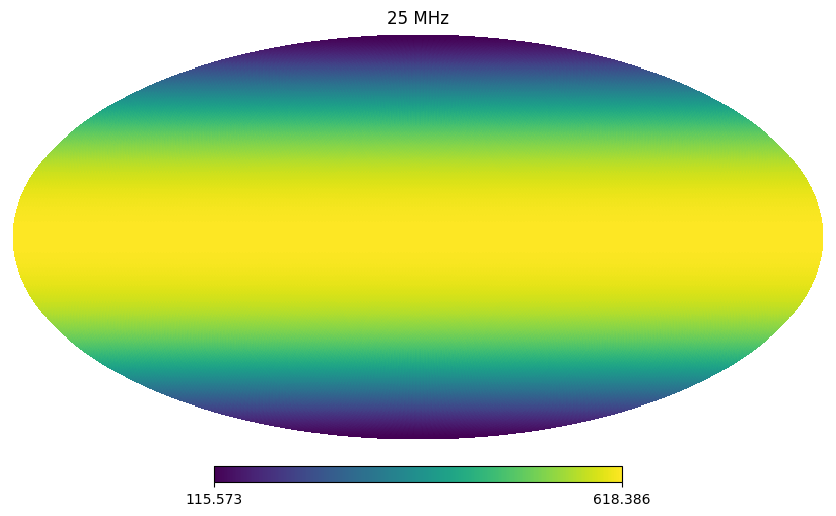

In [7]:
NSIDE = 64
hp_beam = beam.hp_map(NSIDE)
hp.mollview(hp_beam, cbar=True, title=f"{beam.frequencies[0]:.0f} MHz")

In [10]:
beam.alm.shape

(1, 21)

In [19]:
beam[0, 0, 0]

(1740.1025215948123+0j)

In [ ]:
beam.alm[0, ]

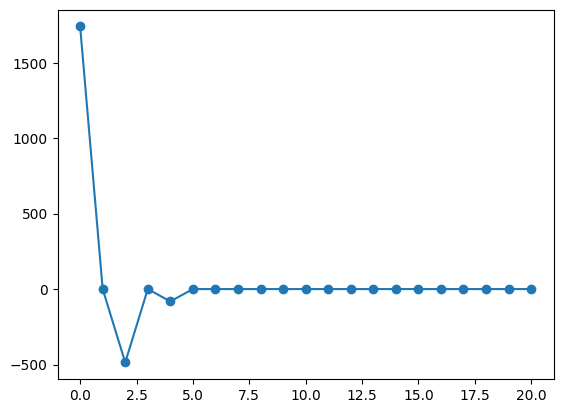

In [12]:
plt.plot(beam.alm[0].real, marker="o")

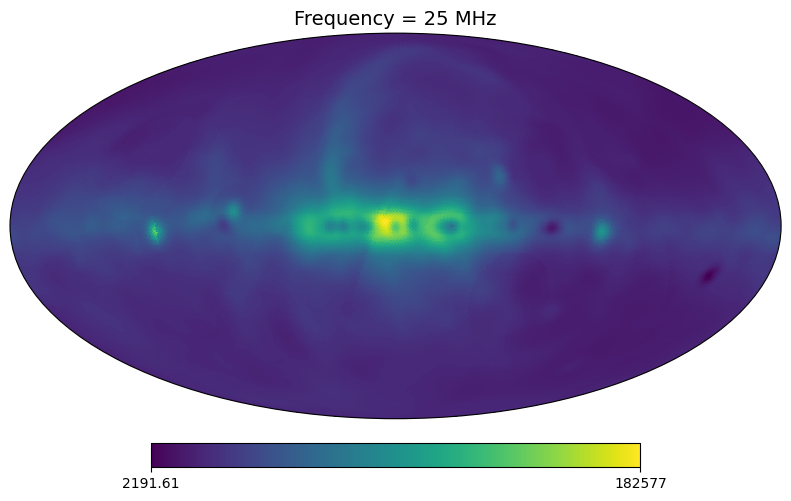

In [63]:
sky = cro.sky.Sky.gsm(beam.frequencies)
sky.plot(frequency=beam.frequencies[0], cbar=True, cb_orientation="horizontal", projection_type="mollweide")

In [198]:
from lunarsky import Time
lmax = 45
loc = (0, 0, 0)
t_start = Time("2023-01-13 15:43:43")
t_end = Time("2023-01-14 15:43:43")
#t_end = Time("2023-02-10 15:43:43")
sim = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=500, t_end=t_end, moon=False, lmax=lmax
)

In [199]:
sim.beam.alm.shape

(1, 1081)

In [200]:
x = np.concatenate((
        sim.sky.alm[0, :sim.lmax+1], sim.sky.alm[0, sim.lmax+1:].real, sim.sky.alm[0, sim.lmax+1:].imag
    ))

In [201]:
x.shape

(2116,)

In [202]:
np.shape(sim.beam.alm * phases)

(500, 1081)

In [203]:
sim.beam

In [204]:
def gen_Ax(sim):
    # make A and x: first m=0 modes, then R(m>0) and Im(m>0) [with the factor of 2 on the beam]
    # absorb the phase rotation of the sky to the A matrix so x is unchanged
    world = "moon" if sim.moon else "earth" 
    phases = sim.sky.rotate_alm_time(sim.dt, world=world)[:, 0]  # rotate sky alms with time
    A_alm = sim.beam.alm * phases
    A = np.concatenate((
        A_alm[:, :sim.lmax+1], 2*A_alm[:, sim.lmax+1:].real, 2*A_alm[:, sim.lmax+1:].imag), axis=-1
    )

    x = np.concatenate((
        sim.sky.alm[0, :sim.lmax+1], sim.sky.alm[0, sim.lmax+1:].real, sim.sky.alm[0, sim.lmax+1:].imag
    ))
    
    return A, x

In [205]:
def estimate_x(sim, noisy=True):
    A, x = gen_Ax(sim)
    y = A @ x
    # construct S matrix
    # get the l values for each index
    ellndx = np.concatenate((hp.Alm.getlm(sim.lmax)[0], hp.Alm.getlm(sim.lmax)[0][sim.lmax+1:]))
    Sell = [(x[ellndx==l_]**2).mean() for l_ in range(lmax+1)]  # this is basically the power spectrum (avg over m's)
    Sdiag = np.array([Sell[l_] for l_ in ellndx])
    S = np.diag(Sdiag)
    #eps = 50
    #S = 1 / eps * np.eye(A.shape[-1])
    #Sdiag = np.diag(S)
    
    if noisy:
        tint = sim.dt[-1] / sim.N_times 
        Ndiag = (y**2) / (1e6 * tint)  # radiometer eq squared, bandwidth = 1 MHz
        noise = np.random.normal(0, 1, y.size) * np.sqrt(Ndiag)
        N = np.diag(Ndiag)

        #print(np.diag(A.T @ np.diag(1/Ndiag) @ A))

        # decide which method to use (yield same result but different computation time)
        if S.shape[0] < N.shape[0]:  # method 5
            Ni = np.diag(1/Ndiag)
            T = A.T @ Ni @ A + np.diag(1/Sdiag)
            W = np.linalg.inv(T) @ A.T @ Ni
        else:
            W = S @ A.T @ np.linalg.inv(A @ S @ A.T + N)  # method 4

        return A, x, S, W @ (y + noise), ellndx  # estimate of x
    
    else:
        W = S @ A.T @ np.linalg.inv(A @ S @ A.T)  # method 4, N = 0
        return W @ y

In [206]:
def real2alm(realalm, lmax, div2=False):
    """
    div2: whether to divide by 2 or not for m>0 modes (True for beam, False for sky)
    """
    realalm = np.copy(realalm).T
    s = hp.Alm.getsize(lmax)
    f = 1/2 if div2 else 1
    return np.concatenate((realalm[:lmax+1], f*realalm[lmax+1:s]+1j*f*realalm[s:]), axis=0).T

In [5]:
def get_mean_vec(alm):
    return alm2rvec(np.hstack((alm[:lmax+1],2*alm[lmax+1:])))#/(4*np.pi))

def alm2rvec (alm):
    return np.hstack((np.real(alm[:lmax+1]),np.real(alm[lmax+1:]),np.imag(alm[lmax+1:])))

def rotate_phi(malm, phi):
    r=hp.Rotator(rot=[0, 0, phi], eulertype='Y')
    return r.rotate_alm(malm)

def rvec2alm (rvec):
    f=rvec[:lmax+1]
    s,si = (rvec[lmax+1:].reshape((2,-1)))
    return np.hstack((f.astype(complex),s+1j*si))


def get_map(beamsl, phil, mpl, totint=200):

    ## build the A matrix
    A= []
    for Bl,phir in zip(beamsl,phil):
        #print(phir)
        for phi in phir:
            Br = rotate_phi(Bl,phi)
            line = get_mean_vec(Br)
            A.append(line)
    A=np.array(A)
    xt = alm2rvec(mpl)
    
    ## now get SNR matrix and N matrix
    ellndx = []
    for l in range(lmax+1):
        ellndx.append(np.arange(l,lmax+1))
    for l in range(1,lmax+1):
        ellndx.append(np.arange(l,lmax+1))
    ellndx = np.hstack(ellndx)
    Sell = [(xt[ellndx==l_]**2).mean() for l_ in range(lmax+1)]
    Sdiag = np.array([Sell[l_] for l_ in ellndx])
    tint = (totint*3600/A.shape[0])#*2 # auto and cross
    data =np.dot(A,xt)
    Ndiag = (data**2)/(1e6* tint)
    noise = np.random.normal(0,1,len(data))*np.sqrt(Ndiag)

    S = np.diag(Sdiag)
    N = np.diag(Ndiag)
    Ni = np.diag(1/Ndiag)
    Si = np.diag(1/Sdiag)
    print (S.shape, N.shape)
    
    ## now get the weight matrix
    if S.shape[0]<N.shape[0]:
        T = A.T@Ni@A+Si
        W = np.linalg.inv(T)@A.T@Ni
    else:
        W = S@A.T@np.linalg.inv(A@S@A.T+N)
    ## and multiply
    res = np.dot(W,data+noise)
    
    ## and make a map
    mapp = hp.alm2map(rvec2alm(res),nside=NSIDE)
    return A, xt, S, mapp, ellndx

In [208]:
A, x, S, res, ls = estimate_x(sim, noisy=True)

x_est = real2alm(res, lmax)

In [209]:
sim.beam.alm.shape

(1, 1081)

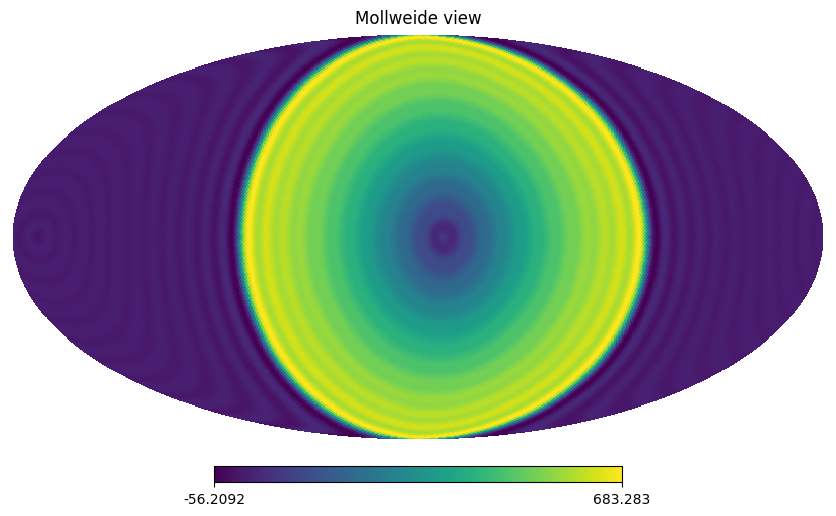

In [210]:
hp.mollview(hp.alm2map(sim.beam.alm[0], NSIDE))

In [211]:
rot_ce = hp.Rotator(coord=["C", "E"])  # celestial to elliptic
beamsl = [rot_ce.rotate_alm(sim.beam.alm[0])]
mapl = rot_ce.rotate_alm(sim.sky.alm[0])
phil = [360 * sim.dt / cro.constants.sidereal_day_earth]

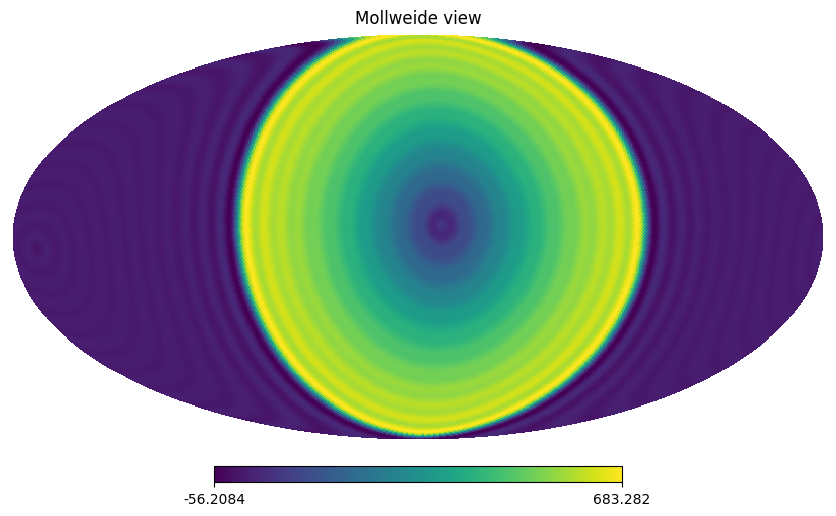

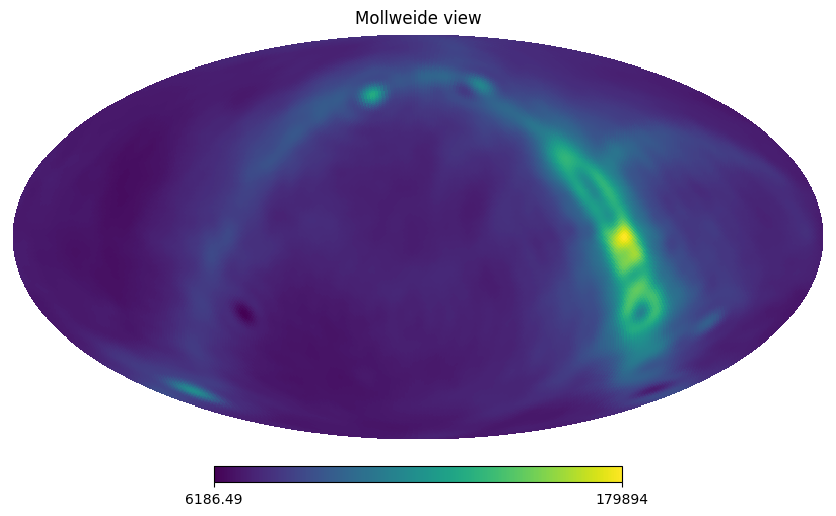

In [212]:
hp.mollview(hp.alm2map(beamsl[0], NSIDE))
hp.mollview(hp.alm2map(mapl, NSIDE))

In [213]:
Aslo, xslo, Sslo, mas, lslo = get_map(beamsl, phil, mapl)

(2116, 2116) (500, 500)


In [214]:
np.allclose(rot_ce.rotate_alm(real2alm(A[0], lmax, div2=True)), real2alm(Aslo[0], lmax, div2=True))

True

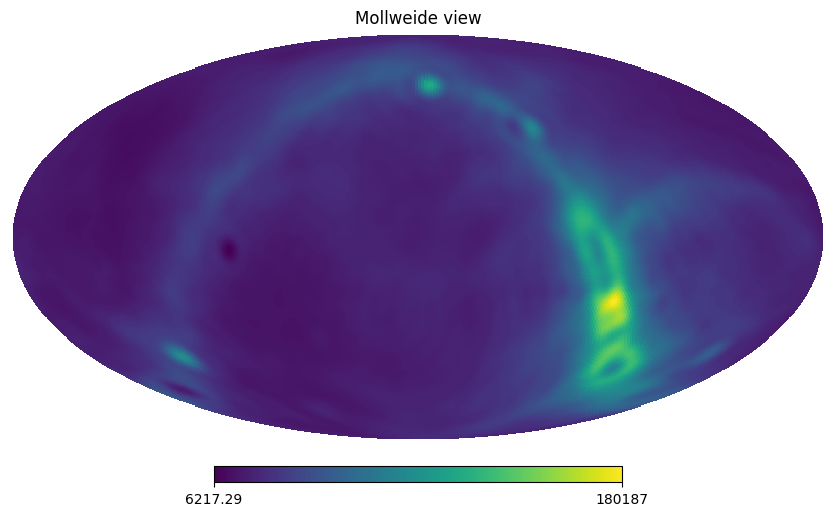

In [216]:
xalm = real2alm(x, lmax)
hp.mollview(hp.alm2map(xalm, NSIDE))

In [217]:
xsloalm = real2alm(xslo, lmax)

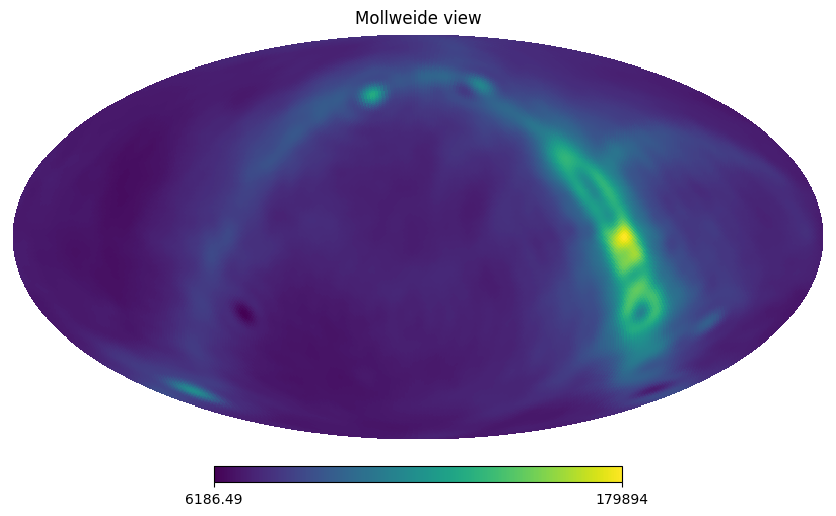

In [218]:
hp.mollview(hp.alm2map(xsloalm, NSIDE))

In [219]:
x.shape

(2116,)

In [220]:
A.shape

(500, 2116)

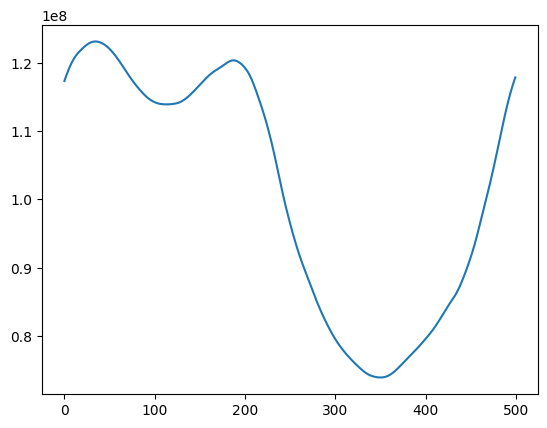

In [221]:
plt.plot(A @ x)

In [222]:
np.allclose(xalm, sim.sky.alm[0])

True

In [223]:
np.allclose(rot_ce.rotate_alm(xalm), xsloalm)

True

In [224]:
S.shape

(2116, 2116)

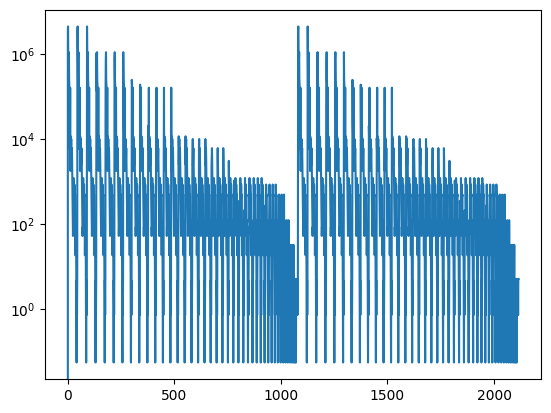

In [225]:
plt.plot(np.abs(np.diag(S)-np.diag(Sslo)))
plt.yscale("log")

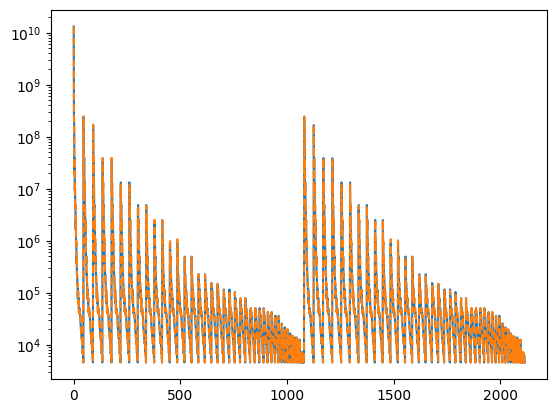

In [226]:
plt.plot(np.diag(S))
plt.plot(np.diag(Sslo), ls="--")
plt.yscale("log")

In [227]:
Sslo.sum() / S.sum().real

1.0000054051081564

In [228]:
np.diag(Sslo).min()

4588.529957266154

In [229]:
np.diag(Sslo).max() / np.diag(S).max().real

1.0

In [230]:
np.diag(Sslo).min() / np.diag(S).min().real

1.0010928525301743

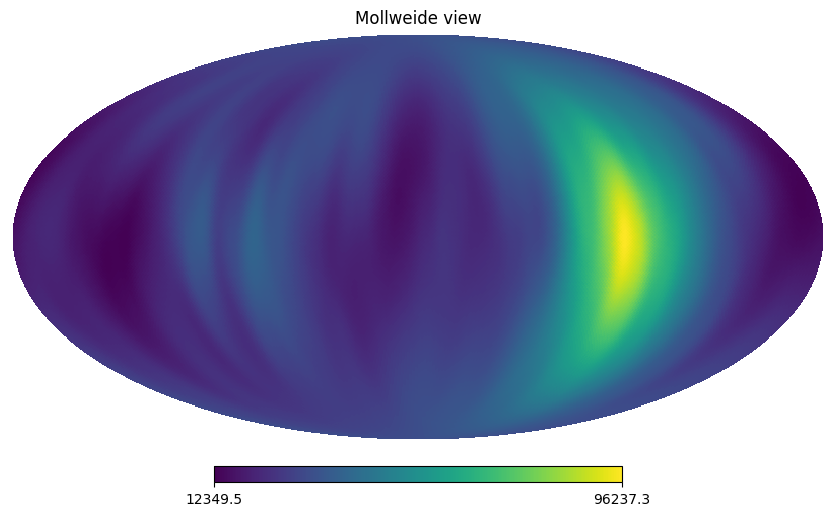

In [231]:
hp.mollview(mas)

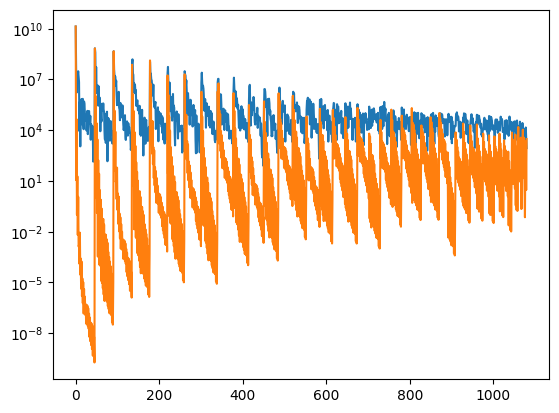

In [232]:
plt.figure()
plt.plot(np.abs(sim.sky.alm[0])**2)
plt.plot(np.abs(x_est)**2)
plt.yscale("log")
#plt.ylim(1e3, 1e9)
plt.show()

In [233]:
map_true = hp.alm2map(sim.sky.alm[0], NSIDE)
map_est = hp.alm2map(x_est, NSIDE)

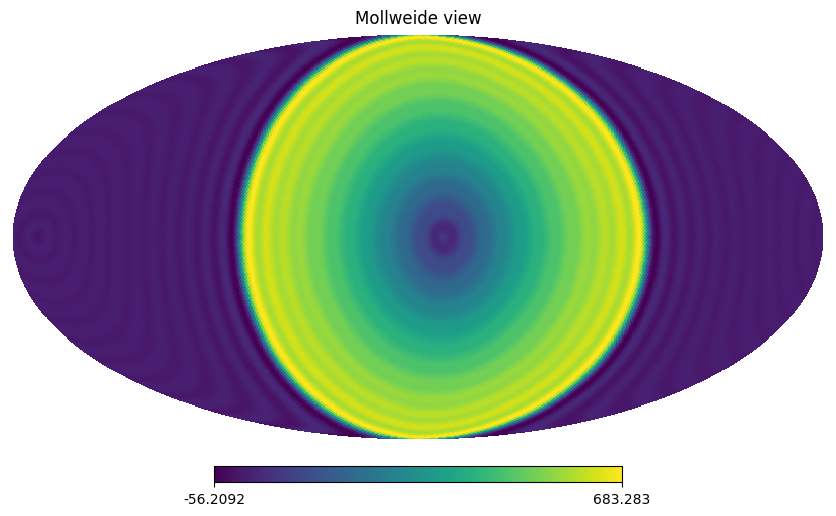

In [234]:
hp.mollview(hp.alm2map(sim.beam.alm[0], NSIDE))

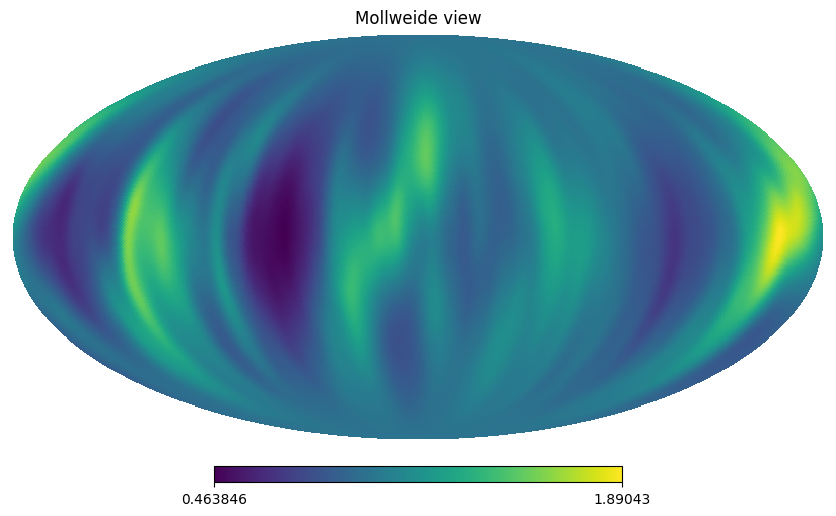

In [235]:
hp.mollview(map_est/mas)

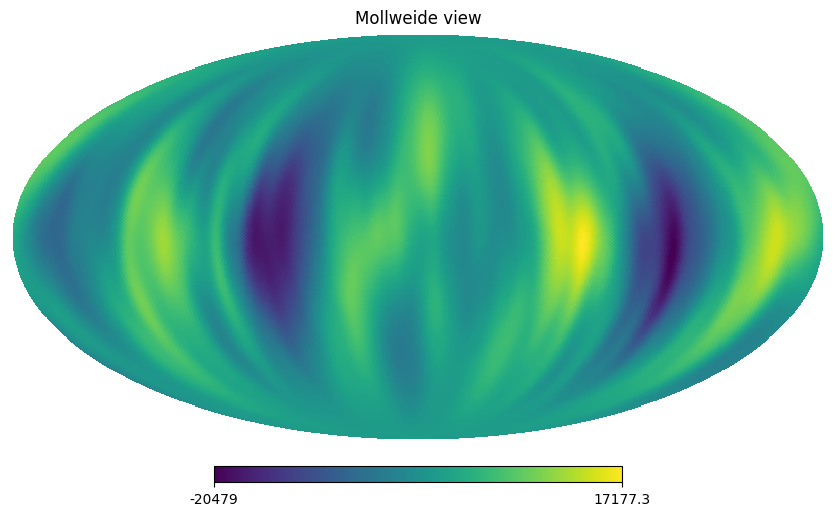

In [236]:
hp.mollview(map_est-mas)

In [237]:
np.allclose(map_est, mas)

False

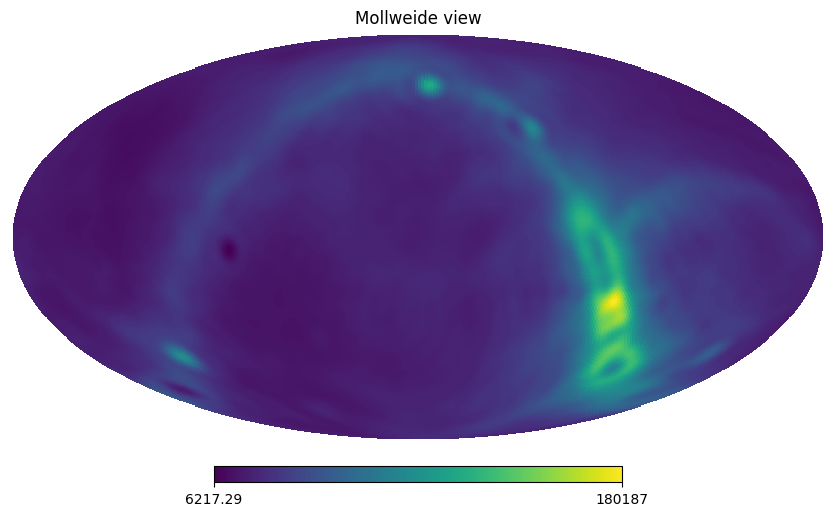

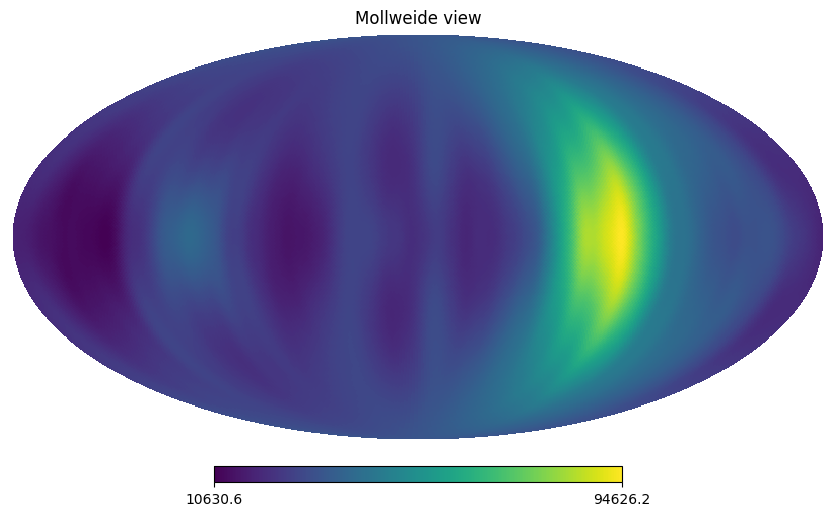

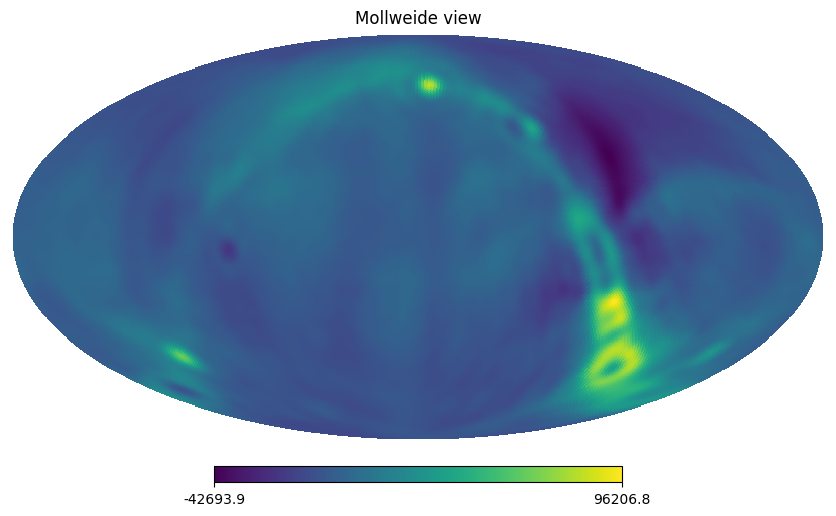

In [238]:
cmap = None
# cmap = "afmhot"
hp.mollview(map_true, cmap=cmap)
hp.mollview(map_est, cmap=cmap)
hp.mollview(map_true - map_est, cmap=cmap)

# Fiore Primary Beam

In [ ]:
fname = "GainPlot_FIORE_Moon_05MHz_monopole_6m.csv"
data = np.loadtxt(fname, delimiter=",", skiprows=1)
data = np.delete(data, np.argwhere(data[:, 0]==360)[:, 0], axis=0)  # remove phi = 360 since we have phi = 0
phi, theta, gain = data.T
phi = np.unique(phi) * np.pi / 180
theta = np.unique(theta) * np.pi / 180
gain = gain.reshape(theta.size, phi.size)

beam = cro.beam.Beam(gain, theta=theta, phi=phi, frequencies=5)
hp_beam = cro.healpix.grid2healpix(beam.data, NSIDE, theta=beam.theta, phi=beam.phi)
hp.mollview(hp_beam[0], cbar=True, title=f"{beam.frequencies[0]:.0f} MHz")

In [ ]:
t_start = Time("2023-01-13 15:43:43")
t_end = Time("2024-01-13 15:43:43")

sim = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=5000, t_end=t_end, moon=False, lmax=lmax
)

res = estimate_x(sim)
n_m0 = sim.lmax + 1  # number of m=0 modes
n_mpos = hp.Alm.getsize(sim.lmax) - n_m0  # number of positive m modes
x_est = np.concatenate((res[:sim.lmax+1], res[-n_mpos:]))

In [ ]:
map_true = hp.alm2map(sim.sky.alm[0], NSIDE)
map_est = hp.alm2map(x_est, NSIDE)

In [ ]:
hp.mollview(hp.alm2map(sim.beam.alm[0], NSIDE))

In [ ]:
hp.mollview(map_true)
hp.mollview(map_est)
hp.mollview(map_true - map_est)

In [ ]:
map_est_pos = map_est.copy()
map_est_pos[map_est_pos < 0] = 1e-3
hp.mollview(np.log10(map_true))
hp.mollview(np.log10(map_est_pos), min=3.5)

# Fiore synthetic beam

In [ ]:
fname = "GainPlot_FIORE_Moon_05MHz_monopole_6m.csv"
data = np.loadtxt(fname, delimiter=",", skiprows=1)
data = np.delete(data, np.argwhere(data[:, 0]==360)[:, 0], axis=0)  # remove phi = 360 since we have phi = 0
phi, theta, gain = data.T
phi = np.unique(phi) * np.pi / 180
theta = np.unique(theta) * np.pi / 180
gain = gain.reshape(theta.size, phi.size)

hp_beam = cro.healpix.grid2healpix(gain, NSIDE, theta=theta, phi=phi)
hp.mollview(hp_beam[0], cbar=True, title=f"{beam.frequencies[0]:.0f} MHz")
#beam_alm = hp.map2alm(hp_beam[0], lmax=lmax, use_pixel_weights=True)

In [ ]:
def rotate_2beam(m,phi_d,dec_d,D,NS, phase):
    r=hp.Rotator(rot=[0, 90-dec_d, phi_d], eulertype='Y')
    T, P = hp.pix2ang(NSIDE, np.arange(12*NSIDE**2))
    mr = r.rotate_map_alms(m*np.cos(2*np.pi*D*np.sin(T)*np.sin(P+NS)+phase))
    return mr

B = rotate_2beam(hp_beam[0], 0,90,5,0.6,np.pi/2)
hp.mollview(B)

In [ ]:
t_start = Time("2023-01-13 15:43:43")
t_end = Time("2024-01-13 15:43:43")

In [ ]:
from astropy_healpix import HEALPix
from astropy.coordinates import AltAz, EarthLocation, SkyCoord


In [ ]:
altaz = AltAz(location=EarthLocation(*loc), obstime=t_start)
hpm = HEALPix(nside=NSIDE, order="ring", frame=altaz)

In [ ]:
lon, lat = hp.pix2ang(NSIDE, np.arange(12*NSIDE**2), lonlat=True)
sc = SkyCoord(lon, lat, unit="deg", frame="icrs")
Beq = hpm.interpolate_bilinear_skycoord(sc, B)

In [ ]:
hp.mollview(Beq)

In [ ]:
# get the beam in equatorial coords (see issue 25 on github)

beam = cro.beam.Beam(hp.map2alm(Beq, lmax=lmax, use_pixel_weights=True), frequencies=5, alm=True)

In [ ]:
sim = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=5000, t_end=t_end, moon=False, lmax=lmax
)

res = estimate_x(sim)
n_m0 = sim.lmax + 1  # number of m=0 modes
n_mpos = hp.Alm.getsize(sim.lmax) - n_m0  # number of positive m modes
x_est = np.concatenate((res[:sim.lmax+1], res[-n_mpos:]))

In [ ]:
map_true = hp.alm2map(sim.sky.alm[0], NSIDE)
map_est = hp.alm2map(x_est, NSIDE)

In [ ]:
hp.mollview(hp.alm2map(sim.beam.alm[0], NSIDE))  # should be rotated (look like B_eq, not B)

In [ ]:
hp.mollview(map_true)
hp.mollview(map_est)
hp.mollview(map_true - map_est)

In [ ]:
map_est_pos = map_est.copy()
map_est_pos[map_est_pos < 0] = 1e-3
hp.mollview(np.log10(map_true))
hp.mollview(np.log10(map_est_pos), min=.05, max=7)

# Dipole in real space

Let's try the methods from Liu&Shaw: https://arxiv.org/pdf/1907.08211.pdf (section 10 / p.40)

We converted to spherical harmonics above. Here, we instead work in real space:

$$T_A(\nu) = \int \mathrm{d}\Omega A^p(\nu, \Omega) T^b(\nu, \Omega) \\
T_A(\nu) \approx \frac{4\pi}{\rm Npix} \sum_{n=1}^{\rm Npix} A^p_n(\nu) T^b_n(\nu) $$

The design matrix $\mathbf{A}$ will be given by $\rm{Ntimes}$ column vectors, each of the form $\mathbf{A_i} = A^p_n(\nu, t_i)$ for each time step $i$. Note that we rotate the beam and not the sky in this case.

The map vector $x$ is in this case simply the sky brightness temperature at the initial time in healpix coordinates.

In [ ]:
nside = 16
sky = cro.sky.Sky.gsm(50, nside=16)
sky.plot(50)

In [ ]:
NSIDE = sky.nside
NPIX = sky.npix

In [ ]:
# initialize a dipole beam at 50 MHz
theta = np.linspace(0, np.pi, num=181)
phi = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
phi.shape = (1, 1, -1)
freq = np.array([50])
# dipole beam
power = freq[:, None]**2 * np.cos(theta[None, :])**2 / freq.max()**2
power = np.repeat(power, phi.size, axis=-1)
beam = cro.beam.Beam(power, theta=theta, phi=phi, frequencies=freq)
beam.horizon_cut()

In [ ]:
hp_beam = cro.healpix.grid2healpix(beam.data, NSIDE, theta=beam.theta, phi=beam.phi)
hp.mollview(hp_beam[0], cbar=True, title=f"{beam.frequencies[0]:.0f} MHz", min=0, max=1)

In [ ]:
from astropy import units
loc = (-10, 20., 0)
t_start = Time("2023-01-13 15:43:43", location=loc)
t_end = Time("2023-01-23 15:43:43", location=loc)
dt = t_end - t_start
ntimes = 256
times, tint = np.linspace(0, dt.sec, ntimes, retstep=True)

In [ ]:
def beam_radec(beam, time, loc=loc, nside=NSIDE):
    """
    Get the healpix map of the beam in the equitorial coordinate system.
    """
    # get lon/lat in sim coordinates at healpix centers
    lon, lat = cro.healpix.healpix2lonlat(nside)

    # get corresponding theta/phi in topocentric coords
    za = np.pi / 2 - np.deg2rad(lat)
    az = np.deg2rad(lon)
    theta, phi = cro.rotations.rot_coords(
        za,
        az,
        "equatorial",
        "topocentric",
        time=time,
        loc=loc,
        lonlat=False,
    )

    pixel_centers = np.array([theta, phi]).T
    # get healpix map
    hp_map = cro.healpix.grid2healpix(
        beam.data,
        nside,
        beam.theta,
        beam.phi,
        pixel_centers=pixel_centers,
    )
    return hp_map

In [ ]:
x = sky.data[0]
A = np.empty((ntimes, NPIX))

lon, lat = hp.pix2ang(NSIDE, np.arange(NPIX), lonlat=True)

for i, t in enumerate(times):
    time = t_start + t * units.s
    A[i] = beam_radec(beam, time)

In [ ]:
y = A @ x
Ndiag = (y**2) / (1e6 * tint)  # radiometer eq squared, bandwidth = 1 MHz
N = np.diag(Ndiag)
noise = np.random.normal(0, 1, y.size) * np.sqrt(Ndiag)
y += noise

In [ ]:
plt.figure()
plt.plot(y/1e7)
plt.show()

## Method 1: Dirty Map

$$\mathbf{\tilde{x}} = \mathbf{A}^t \mathbf{N}^{-1} \mathbf{y} $$

In [ ]:
x_dirty = A.T @ np.linalg.inv(N) @ y
hp.mollview(x_dirty)
hp.mollview(x)

## Method 2: Maximum Likelihood

No unmeasured modes:
$$\mathbf{\tilde{x}} = \left(\mathbf{A^t} \mathbf{N}^{-1} \mathbf{A} \right)^{-1}\mathbf{A}^t \mathbf{N}^{-1} \mathbf{y} = \left(\mathbf{A^t} \mathbf{N}^{-1} \mathbf{A} \right)^{-1} \mathbf{\tilde{x}}_{\rm dirty} $$

Unmeasured modes:
$$\mathbf{\tilde{x}} = \left( \mathbf{N}^{-1/2} \mathbf{A} \right)^+ \mathbf{N}^{-1/2} \mathbf{y}$$

In [ ]:
# x_ml = np.linalg.inv(A.T @ np.linalg.inv(N) @ A) @ A.T @ np.linalg.inv(N) @ y

In [ ]:
A[A<1e-8] = 0
y = A @ x + noise
Ninv_sq = np.diag(1/np.sqrt(np.diag(N)))
x_ml = np.linalg.pinv(Ninv_sq @ A) @ Ninv_sq @ y

In [ ]:
hp.mollview(x_ml)
hp.mollview(x)

In [ ]:
hp.mollview(x_ml, min=0, max=1e6)
hp.mollview(x)

In [ ]:

S = np.diag(Sdiag)
    N = np.diag(Ndiag)
    
    # decide which method to use (yield same result but different computation time)
    if S.shape[0] < N.shape[0]:  # method 5
        Ni = np.diag(1/Ndiag)
        T = A.T @ Ni @ A + np.diag(1/Sdiag)
        W = np.linalg.inv(T) @ A.T @ Ni
    else:
        W = S @ A.T @ np.linalg.inv(A @ S @ A.T + N)  # method 4

    return W @ (y + noise)  # estimate of x

# Fiore (Anze)

In [6]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from  scipy.interpolate import interp1d

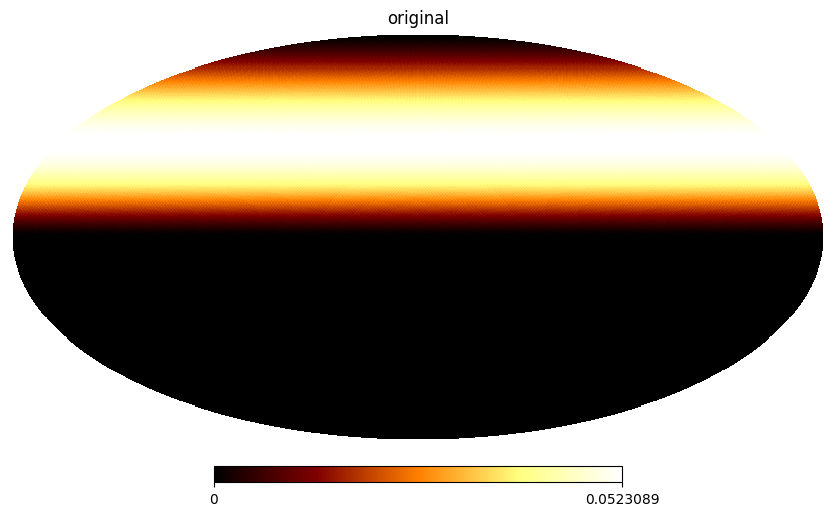

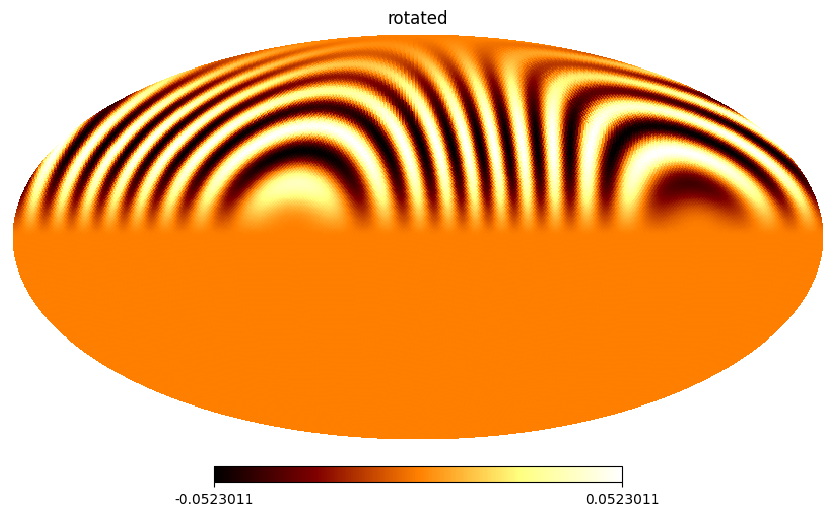

In [11]:
from  scipy.interpolate import interp1d
NSIDE = 64
Npix = 12*NSIDE**2
theta_p,phi_p = hp.pix2ang(Nside,np.arange(Npix))
lmax=45

def read_beam(fname):
    data = open(fname).readlines()[1:]
    data = np.array([[float(x) for x in d.split(',')] for d in data])
    data = np.array(data)
    data = data[data[:,0]==5] ## pick some phi
    gain_theta = interp1d (data[:,1]/180*np.pi,data[:,2])
    B = gain_theta(theta_p)
    return B


def mean_alm(alm1, alm2):
    prod = alm1*np.conj(alm2)
    sm = (np.real(prod[:lmax+1]).sum()+2*np.real(prod[lmax+1:]).sum())/(4*np.pi)
    return sm


def rotate_2beam(m,phi_d,dec_d,D,NS, phase):
    r=hp.Rotator(rot=[0, 90-dec_d, phi_d], eulertype='Y')
    mr = r.rotate_map_alms(m*np.cos(2*np.pi*D*np.sin(theta_p)*np.sin(phi_p+NS)+phase))
    return mr




B0=read_beam('GainPlot_FIORE_Moon_05MHz_monopole_6m.csv')
B = rotate_2beam(B0,0,90,5,0.6,np.pi/2)
hp.mollview(B0,title="original",cmap='afmhot')
hp.mollview(B,title="rotated",cmap='afmhot')

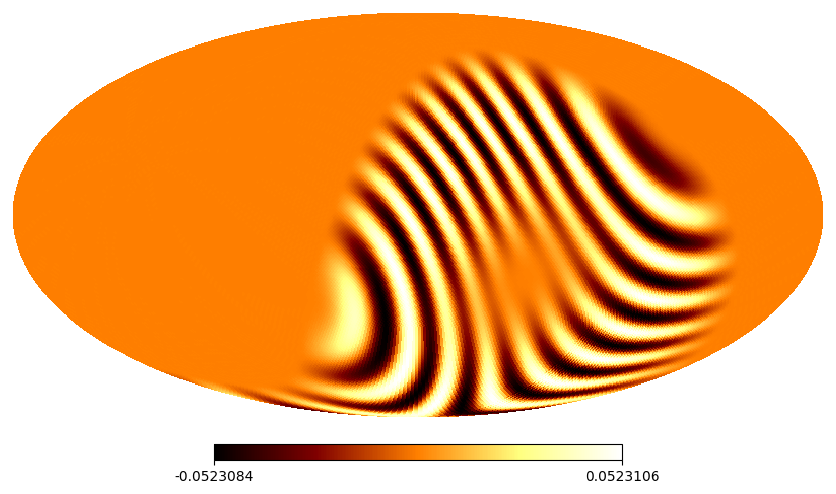

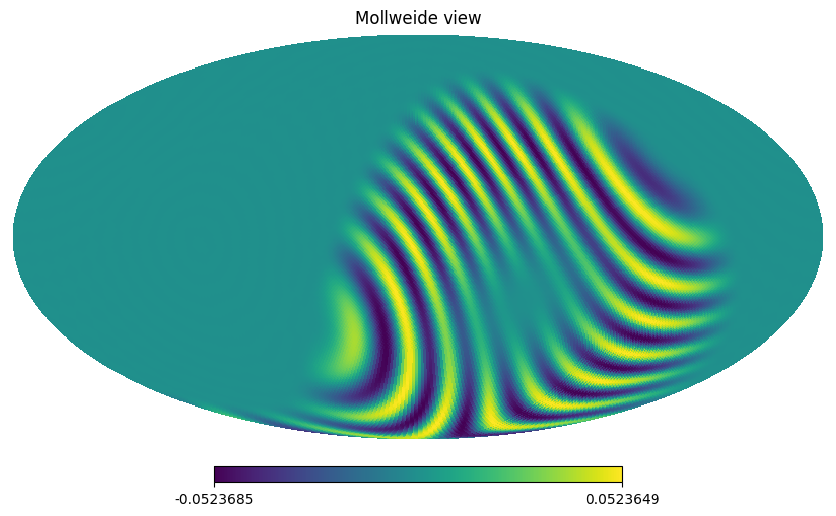

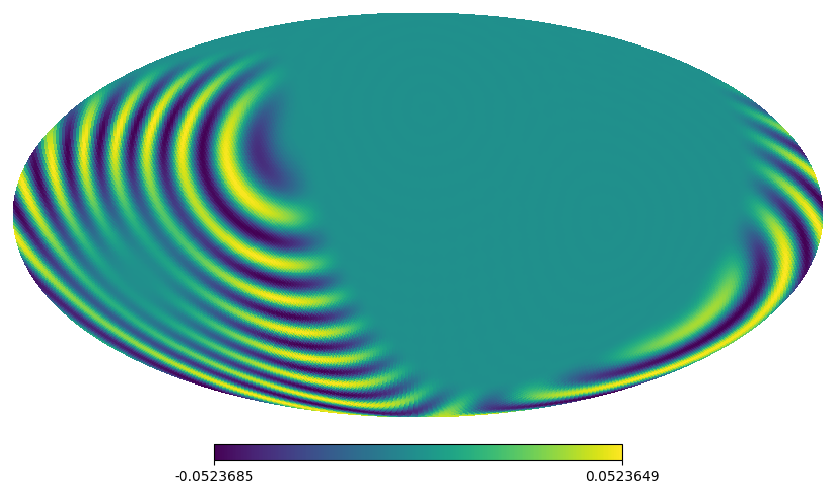

In [12]:
B = rotate_2beam(B0,50,-23,5,0.6,np.pi/2)
hp.mollview(B,title="",cmap='afmhot')
Bl = hp.map2alm(B,lmax=lmax)

hp.mollview(hp.alm2map(Bl,nside=Nside))
hp.mollview(hp.alm2map(rotate_phi(Bl,180),nside=Nside),title="")

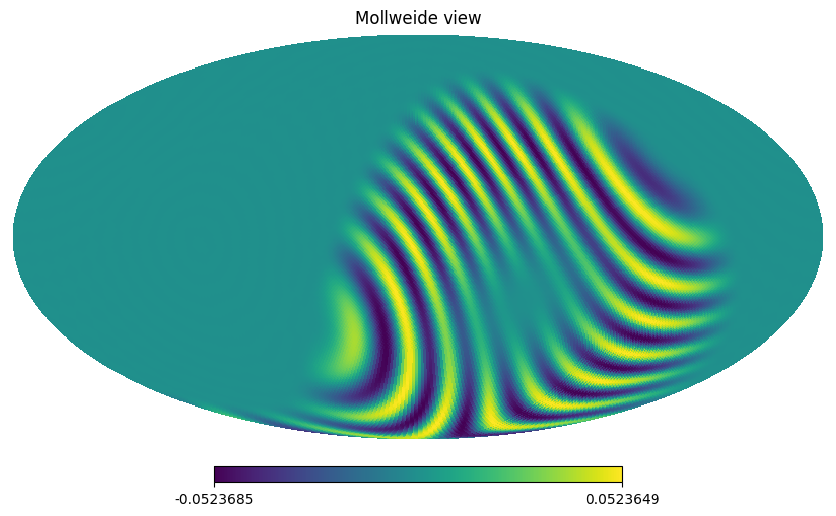

In [13]:
hp.mollview(hp.alm2map(Bl, nside=NSIDE))

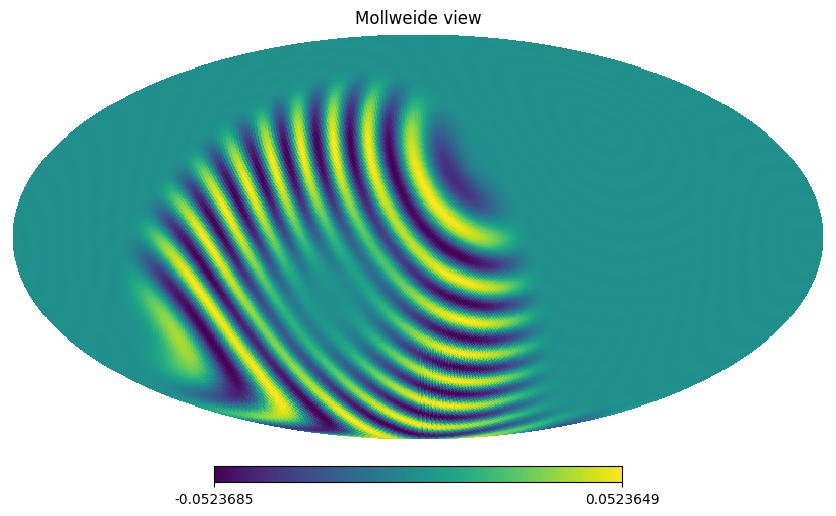

In [14]:
hp.mollview(hp.alm2map(rotate_phi(Bl, 270), nside=NSIDE))

In [15]:
bll = get_mean_vec(Bl)

50


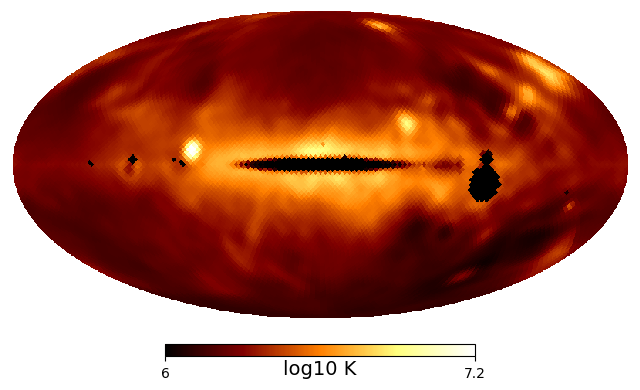

In [16]:
mpG = np.load("ulsa_sky_32_kelvin.npy")
print (len(mpG))
mpG = mpG[4,:]
plt.figure(figsize=(8,6))
hp.mollview(np.log10(mpG),hold=True, title="",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')

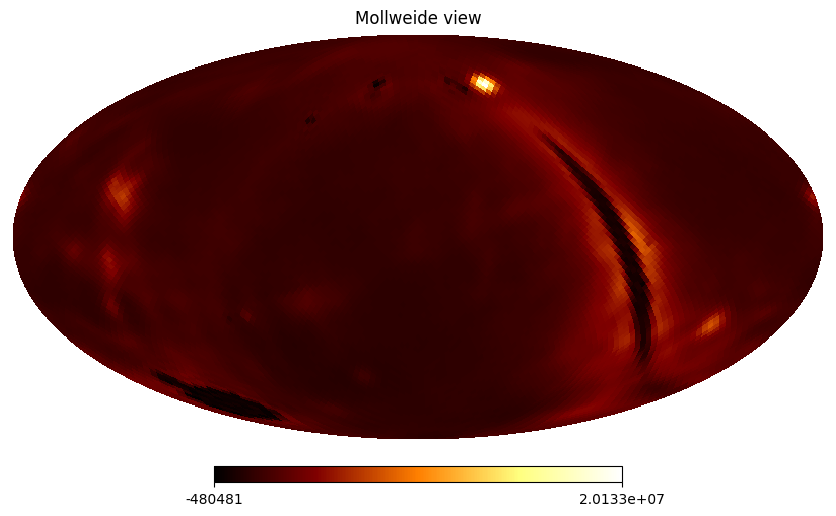

In [17]:
mp = hp.Rotator(coord=['G','E']).rotate_map_alms(mpG)
hp.mollview(mp,cmap='afmhot')

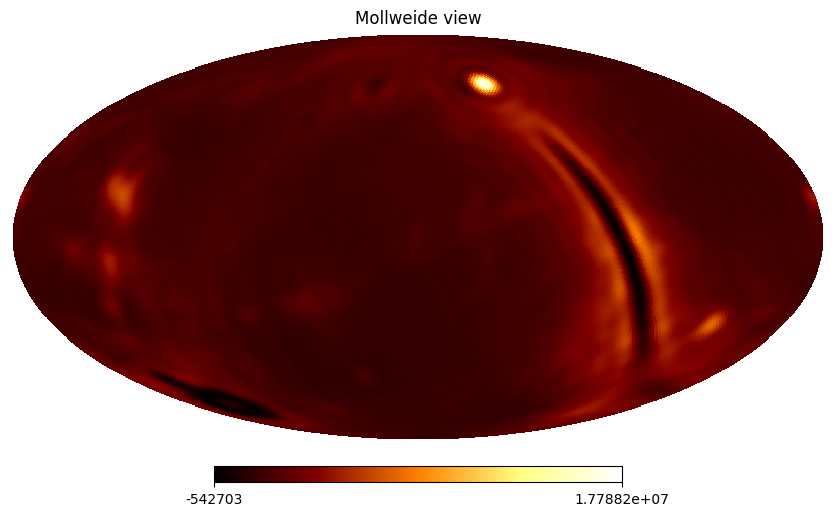

In [18]:
mpl = hp.map2alm(mp,lmax=lmax)
hp.mollview(hp.alm2map(mpl,nside=Nside),cmap='afmhot')

In [19]:


def get_map(beamsl,phil, totint = 200):

    ## build the A matrix
    A= []
    for Bl,phir in zip(beamsl,phil):
        #print(phir)
        for phi in phir:
            Br = rotate_phi(Bl,phi)
            line = get_mean_vec(Br)
            A.append(line)
    A=np.array(A)
    xt = alm2rvec(mpl)
    
    ## now get SNR matrix and N matrix
    ellndx = []
    for l in range(lmax+1):
        ellndx.append(np.arange(l,lmax+1))
    for l in range(1,lmax+1):
        ellndx.append(np.arange(l,lmax+1))
    ellndx = np.hstack(ellndx)
    Sell = [(xt[ellndx==l_]**2).mean() for l_ in range(lmax+1)]
    Sdiag = np.array([Sell[l_] for l_ in ellndx])
    tint = (totint*3600/A.shape[0])#*2 # auto and cross
    data =np.dot(A,xt)
    Ndiag = (data**2)/(1e6* tint)
    noise = np.random.normal(0,1,len(data))*np.sqrt(Ndiag)

    S = np.diag(Sdiag)
    N = np.diag(Ndiag)
    Ni = np.diag(1/Ndiag)
    Si = np.diag(1/Sdiag)
    print (S.shape, N.shape)
    
    ## now get the weight matrix
    if S.shape[0]<N.shape[0]:
        T = A.T@Ni@A+Si
        W = la.inv(T)@A.T@Ni
    else:
        W = S@A.T@la.inv(A@S@A.T+N)
    ## and multiply
    res = np.dot(W,data+noise)
    
    ## and make a map
    mapp = hp.alm2map(rvec2alm(res),nside=Nside)
    return mapp

0.0 0.0


(-320.0, 320.0)

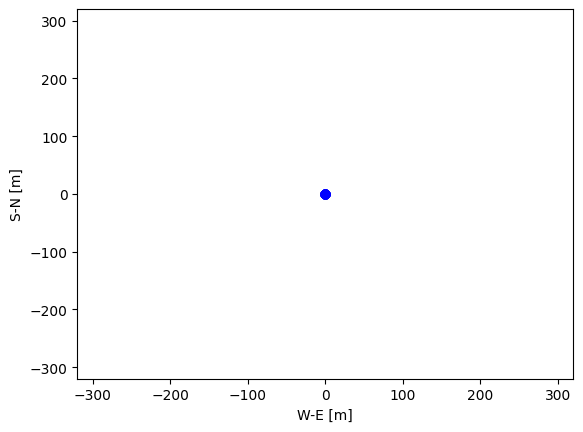

In [20]:


beams = []
rotmax=360*2+270
xl,yl=[],[]
phiofs = -60
phimax = 100
phil = []
steps = 100
Dofs = 0
Dmax = 5
Ndays = 1
for c, ns in enumerate(np.linspace(0, rotmax**(3),steps)):
    ns=ns**(1/3)
#    D = Dofs+ns/rotmax * (Dmax-Dofs)
    D = 0
    if (c==0):
        D=0
    xl.append(D*np.cos(ns/180*np.pi))
    yl.append(D*np.sin(ns/180*np.pi))
    #for phase in [0,np.pi/2]:
    for phase in [0]:
        mr = rotate_2beam(B0,0,-23,D, ns, phase)
        beams.append(mr)
        philx = []
        for days in range(Ndays):
            if D==0:
                philx.append(np.linspace(phiofs+days*30,phiofs+phimax,steps))
            else:
                cstart= phiofs+days*30+c/steps*phimax
                cend = phiofs+days*30+(c+1)/steps*phimax
                philx.append(np.linspace(cstart,cend,10))
        phil.append(np.hstack(philx))

beamsl = [hp.map2alm(b,lmax=lmax) for b in beams]

assert(len(phil)==len(beamsl))

lam_m = 3e8/5e6
xl = np.array(xl)
yl = np.array(yl)
dd = np.sqrt(((xl[1:]-xl[:-1])**2+(yl[1:]-yl[:-1])**2)).sum()
tdrive = dd*lam_m/100 # in hours
print (dd,dd*lam_m/100)



plt.figure()
#plt.subplot(1,2,1)
plt.plot(xl*lam_m,yl*lam_m,'bo--',label=f'phiofs ={phiofs}\nphimax = {phimax}\nwait = {phimax/360*28*24/steps}h')
plt.xlabel('W-E [m]')
plt.ylabel('S-N [m]')
plt.xlim(-320,320)
plt.ylim(-320,320)
#plt.legend()
#plt.subplot(1,2,2)



In [21]:
phil[0]

array([-60.        , -58.98989899, -57.97979798, -56.96969697,
       -55.95959596, -54.94949495, -53.93939394, -52.92929293,
       -51.91919192, -50.90909091, -49.8989899 , -48.88888889,
       -47.87878788, -46.86868687, -45.85858586, -44.84848485,
       -43.83838384, -42.82828283, -41.81818182, -40.80808081,
       -39.7979798 , -38.78787879, -37.77777778, -36.76767677,
       -35.75757576, -34.74747475, -33.73737374, -32.72727273,
       -31.71717172, -30.70707071, -29.6969697 , -28.68686869,
       -27.67676768, -26.66666667, -25.65656566, -24.64646465,
       -23.63636364, -22.62626263, -21.61616162, -20.60606061,
       -19.5959596 , -18.58585859, -17.57575758, -16.56565657,
       -15.55555556, -14.54545455, -13.53535354, -12.52525253,
       -11.51515152, -10.50505051,  -9.49494949,  -8.48484848,
        -7.47474747,  -6.46464646,  -5.45454545,  -4.44444444,
        -3.43434343,  -2.42424242,  -1.41414141,  -0.4040404 ,
         0.60606061,   1.61616162,   2.62626263,   3.63

In [22]:
np.allclose(np.array(beamsl), beamsl[0])

True

In [23]:
sol = get_map(beamsl,phil,totint = Ndays*(220-tdrive))

(2116, 2116) (10000, 10000)


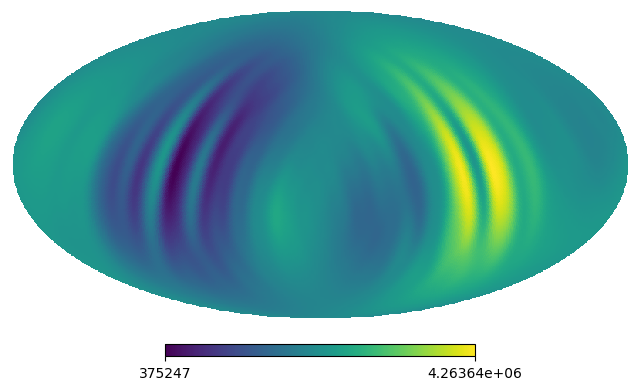

In [27]:
sol[sol<0]=1e-3
plt.figure(figsize=(8,6))
hp.mollview(sol,hold=True, title="")
#hp.mollview(np.log10(sol),hold=True, title="",min=5.5,max=6.8,unit='log10 K',cmap='afmhot')

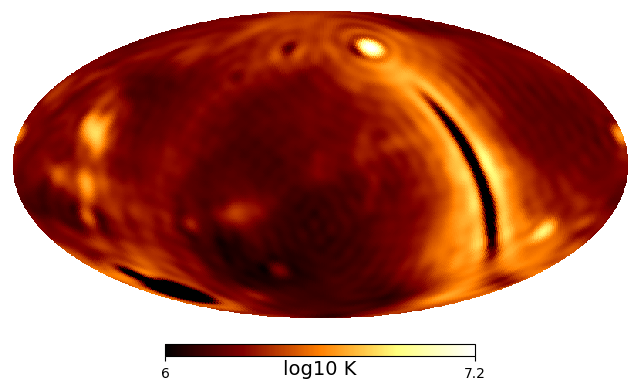

In [25]:
plt.figure(figsize=(8,6))
#hp.mollview(hp.alm2map(mpl,nside=Nside),hold=True, min=0, max=1.1e7,title="")
tsol = hp.alm2map(mpl,nside=Nside)
tsol[tsol<0]=1
hp.mollview(np.log10(tsol),hold=True, title="",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')

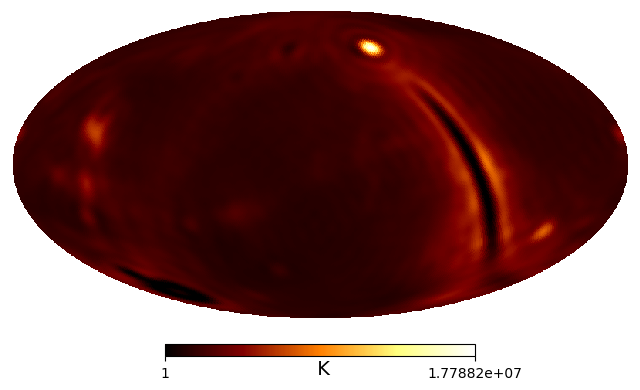

In [26]:
plt.figure(figsize=(8,6))
#hp.mollview(hp.alm2map(mpl,nside=Nside),hold=True, min=0, max=1.1e7,title="")
tsol = hp.alm2map(mpl,nside=Nside)
tsol[tsol<0]=1
hp.mollview(tsol,hold=True, title="",unit=' K',cmap='afmhot')